In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Basic RNNs

### Dummy dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [5]:

np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [6]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

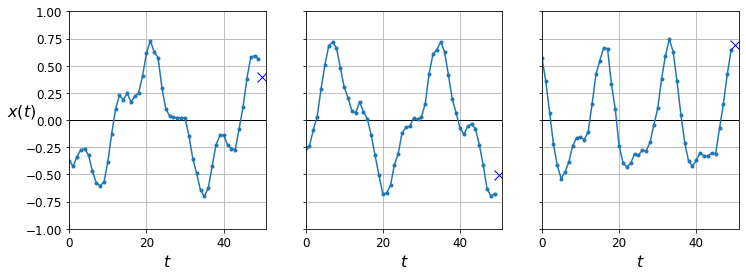

In [8]:

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))


In [28]:
X_train[0]

array([[ 0.4596948 ],
       [ 0.31486678],
       [ 0.12497123],
       [-0.1039134 ],
       [-0.33817387],
       [-0.53167135],
       [-0.65472883],
       [-0.6680997 ],
       [-0.6068115 ],
       [-0.50168324],
       [-0.27951923],
       [-0.15070675],
       [ 0.01001816],
       [ 0.11860766],
       [ 0.09566415],
       [ 0.1479297 ],
       [ 0.16850619],
       [ 0.19524719],
       [ 0.22094081],
       [ 0.38448656],
       [ 0.4021102 ],
       [ 0.5566975 ],
       [ 0.55000687],
       [ 0.47437248],
       [ 0.29733396],
       [ 0.13306592],
       [-0.1292547 ],
       [-0.36367297],
       [-0.49515054],
       [-0.65279794],
       [-0.6665792 ],
       [-0.5604573 ],
       [-0.50344354],
       [-0.28775147],
       [-0.12684062],
       [-0.0095053 ],
       [ 0.12024356],
       [ 0.18013756],
       [ 0.1559989 ],
       [ 0.1756968 ],
       [ 0.217454  ],
       [ 0.30272725],
       [ 0.38143268],
       [ 0.42323437],
       [ 0.46800318],
       [ 0

In [29]:
X_train[0].shape

(50, 1)

#### Computing Baselines

In [11]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

In [ ]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

#### Linear predictions

In [13]:

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 542us/sample - loss: 0.1008 - val_loss: 0.0552
Epoch 2/20
7000/7000 [==============================] - 1s 79us/sample - loss: 0.0388 - val_loss: 0.0270
Epoch 3/20
7000/7000 [==============================] - 1s 74us/sample - loss: 0.0206 - val_loss: 0.0160
Epoch 4/20
7000/7000 [==============================] - 1s 75us/sample - loss: 0.0132 - val_loss: 0.0115
Epoch 5/20
7000/7000 [==============================] - 1s 73us/sample - loss: 0.0103 - val_loss: 0.0097
Epoch 6/20
7000/7000 [==============================] - 1s 73us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 1s 74us/sample - loss: 0.0079 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 1s 79us/sample - loss: 0.0072 - val_loss: 0.0073
Epoch 9/20
7000/7000 [==============================] - 1s 76us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 

In [14]:
model.evaluate(X_valid, y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.004112337179481983

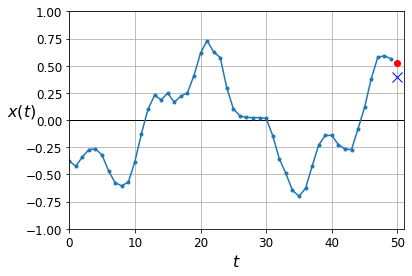

In [15]:

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()


#### Using simple RNN

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 996us/sample - loss: 0.0979 - val_loss: 0.0490
Epoch 2/20
7000/7000 [==============================] - 5s 760us/sample - loss: 0.0371 - val_loss: 0.0297
Epoch 3/20
7000/7000 [==============================] - 5s 748us/sample - loss: 0.0254 - val_loss: 0.0219
Epoch 4/20
7000/7000 [==============================] - 5s 753us/sample - loss: 0.0199 - val_loss: 0.0177
Epoch 5/20
7000/7000 [==============================] - 5s 771us/sample - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
7000/7000 [==============================] - 5s 741us/sample - loss: 0.0146 - val_loss: 0.0135
Epoch 7/20
7000/7000 [==============================] - 5s 771us/sample - loss: 0.0133 - val_loss: 0.0124
Epoch 8/20
7000/7000 [==============================] - 5s 748us/sample - loss: 0.0124 - val_loss: 0.0117
Epoch 9/20
7000/7000 [==============================] - 5s 765us/sample - loss: 0.0119 - val_loss: 0.011

In [17]:
model.evaluate(X_valid, y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.010903828285634517

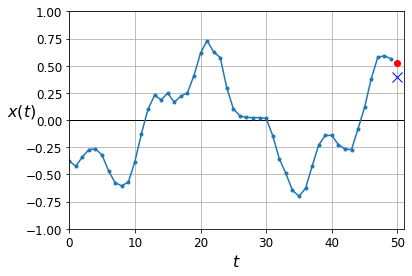

In [18]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

#### Deep RNNs

In [19]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0531 - val_loss: 0.0083
Epoch 2/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0074 - val_loss: 0.0055
Epoch 3/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0054 - val_loss: 0.0050
Epoch 4/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0047 - val_loss: 0.0041
Epoch 5/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0044 - val_loss: 0.0041
Epoch 6/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0041 - val_loss: 0.0040
Epoch 7/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0038 - val_loss: 0.0035
Epoch 8/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0038 - val_loss: 0.0039
Epoch 9/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 1

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


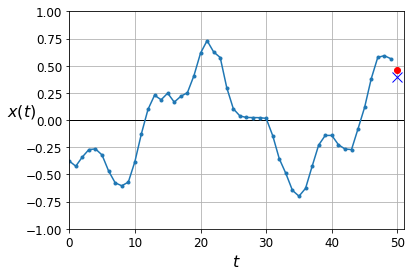

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0240 - val_loss: 0.0050
Epoch 2/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0043 - val_loss: 0.0035
Epoch 3/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0036 - val_loss: 0.0033
Epoch 4/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0034 - val_loss: 0.0032
Epoch 5/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0032 - val_loss: 0.0034
Epoch 7/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0030 - val_loss: 0.0031
Epoch 9/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0030 - val_loss: 0.0031
Epoch 1

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.evaluate(X_valid, y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.0028335101995617153

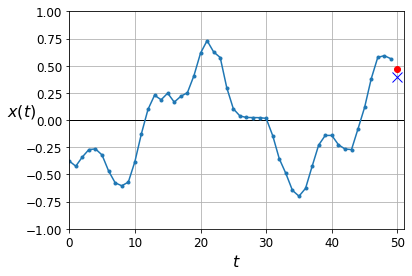

In [27]:

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# Forecasting Several Steps Ahead

In [30]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [31]:
Y_pred.shape

(1, 10, 1)

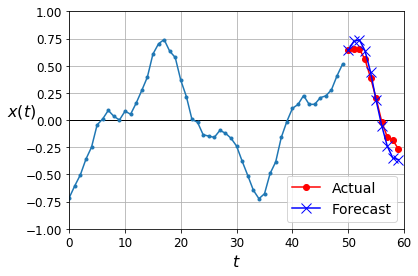

In [34]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)


In [35]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [36]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [37]:

Y_pred.shape

(2000, 10)

In [38]:

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0663 - val_loss: 0.0312
Epoch 2/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0265 - val_loss: 0.0214
Epoch 3/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0187 - val_loss: 0.0203
Epoch 4/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0151 - val_loss: 0.0157
Epoch 5/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0139 - val_loss: 0.0127
Epoch 6/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0127 - val_loss: 0.0114
Epoch 7/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0119 - val_loss: 0.0118
Epoch 8/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0114 - val_loss: 0.0106
Epoch 9/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0110 - val_loss: 0.0116
Epoch 1

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [40]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

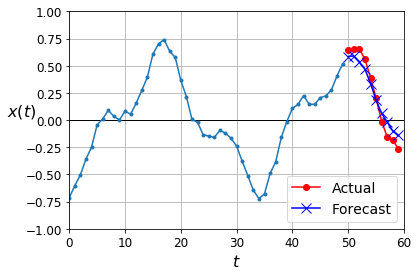

In [41]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Let's try to create a model which will make a prediction of 10 steps ahead at every time step

In [42]:

np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


In [44]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [45]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0502 - last_time_step_mse: 0.0392 - val_loss: 0.0422 - val_last_time_step_mse: 0.0309
Epoch 2/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0403 - last_time_step_mse: 0.0293 - val_loss: 0.0361 - val_last_time_step_mse: 0.0274
Epoch 3/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0406 - last_time_step_mse: 0.0340 - val_loss: 0.0339 - val_last_time_step_mse: 0.0247
Epoch 4/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0337 - last_time_step_mse: 0.0240 - val_loss: 0.0322 - val_last_time_step_mse: 0.0242
Epoch 5/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0289 - last_time_step_mse: 0.0176 - val_loss: 0.0280 - val_last_time_step_mse: 0.0171
Epoch 6/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0253 - last_time_step_mse: 0.0135 - 

In [46]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

# Deep RNN with Batch Norm

In [53]:

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [54]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 20)          80        
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, None, 20)          820       
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 20)          80        
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 10)          210       
Total params: 1,630
Trainable params: 1,550
Non-trainable params: 80
_________________________________________________________________


In [47]:


model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.1935 - last_time_step_mse: 0.1917 - val_loss: 0.0902 - val_last_time_step_mse: 0.0864
Epoch 2/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0535 - last_time_step_mse: 0.0447 - val_loss: 0.0556 - val_last_time_step_mse: 0.0468
Epoch 3/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0470 - last_time_step_mse: 0.0374 - val_loss: 0.0453 - val_last_time_step_mse: 0.0357
Epoch 4/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0436 - last_time_step_mse: 0.0335 - val_loss: 0.0417 - val_last_time_step_mse: 0.0320
Epoch 5/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0408 - last_time_step_mse: 0.0304 - val_loss: 0.0405 - val_last_time_step_mse: 0.0301
Epoch 6/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0385 - last_time_step_mse: 0.0277 - 

# Deep RNNs with Layer Norm

In [48]:
from tensorflow.keras.layers import LayerNormalization

In [49]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [51]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, None, 20)          480       
_________________________________________________________________
rnn_1 (RNN)                  (None, None, 20)          860       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 10)          210       
Total params: 1,550
Trainable params: 1,550
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 31s 4ms/sample - loss: 0.1607 - last_time_step_mse: 0.1574 - val_loss: 0.0727 - val_last_time_step_mse: 0.0663
Epoch 2/20
7000/7000 [==============================] - 28s 4ms/sample - loss: 0.0638 - last_time_step_mse: 0.0526 - val_loss: 0.0581 - val_last_time_step_mse: 0.0450
Epoch 3/20
7000/7000 [==============================] - 27s 4ms/sample - loss: 0.0552 - last_time_step_mse: 0.0428 - val_loss: 0.0521 - val_last_time_step_mse: 0.0396
Epoch 4/20
7000/7000 [==============================] - 28s 4ms/sample - loss: 0.0496 - last_time_step_mse: 0.0381 - val_loss: 0.0468 - val_last_time_step_mse: 0.0357
Epoch 5/20
7000/7000 [==============================] - 27s 4ms/sample - loss: 0.0451 - last_time_step_mse: 0.0341 - val_loss: 0.0429 - val_last_time_step_mse: 0.0308
Epoch 6/20
7000/7000 [==============================] - 28s 4ms/sample - loss: 0.0411 - last_time_step_mse: 0.0294 - 

# LSTMs

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


In [58]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 10)          210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


In [59]:

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 734us/sample - loss: 0.0766 - last_time_step_mse: 0.0628 - val_loss: 0.0555 - val_last_time_step_mse: 0.0371
Epoch 2/20
7000/7000 [==============================] - 2s 302us/sample - loss: 0.0480 - last_time_step_mse: 0.0284 - val_loss: 0.0426 - val_last_time_step_mse: 0.0223
Epoch 3/20
7000/7000 [==============================] - 2s 299us/sample - loss: 0.0391 - last_time_step_mse: 0.0186 - val_loss: 0.0375 - val_last_time_step_mse: 0.0173
Epoch 4/20
7000/7000 [==============================] - 2s 300us/sample - loss: 0.0352 - last_time_step_mse: 0.0154 - val_loss: 0.0334 - val_last_time_step_mse: 0.0133
Epoch 5/20
7000/7000 [==============================] - 2s 299us/sample - loss: 0.0327 - last_time_step_mse: 0.0134 - val_loss: 0.0316 - val_last_time_step_mse: 0.0124
Epoch 6/20
7000/7000 [==============================] - 2s 302us/sample - loss: 0.0311 - last_time_step_mse: 0.0

In [60]:

model.evaluate(X_valid, Y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.023756909608840943, 0.008638692]

In [61]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

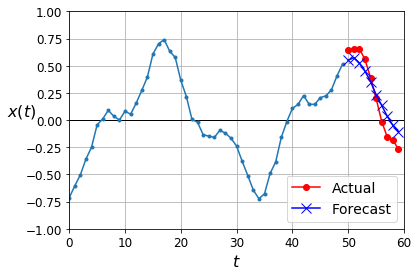

In [62]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [63]:

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [64]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 20)          1380      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 10)          210       
Total params: 4,110
Trainable params: 4,110
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 708us/sample - loss: 0.0745 - last_time_step_mse: 0.0668 - val_loss: 0.0526 - val_last_time_step_mse: 0.0413
Epoch 2/20
7000/7000 [==============================] - 2s 279us/sample - loss: 0.0478 - last_time_step_mse: 0.0369 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
7000/7000 [==============================] - 2s 278us/sample - loss: 0.0420 - last_time_step_mse: 0.0306 - val_loss: 0.0395 - val_last_time_step_mse: 0.0275
Epoch 4/20
7000/7000 [==============================] - 2s 281us/sample - loss: 0.0375 - last_time_step_mse: 0.0250 - val_loss: 0.0346 - val_last_time_step_mse: 0.0205
Epoch 5/20
7000/7000 [==============================] - 2s 280us/sample - loss: 0.0327 - last_time_step_mse: 0.0178 - val_loss: 0.0311 - val_last_time_step_mse: 0.0156
Epoch 6/20
7000/7000 [==============================] - 2s 280us/sample - loss: 0.0309 - last_time_step_mse: 0.0

In [66]:
model.evaluate(X_valid, Y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.024027100265026094, 0.010358047]

In [67]:

np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

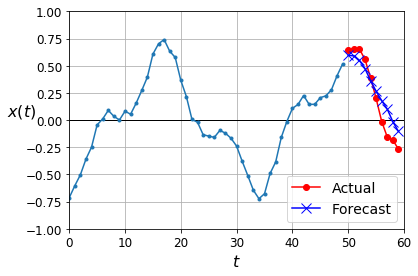

In [68]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()